In [1]:

!pip install torch
!pip install pytorch_pretrained_bert
!pip install tqdm boto3 requests regex sentencepiece sacremoses
!pip install transformers

     |████████████████████████████████| 123 kB 10.0 MB/s 
     |████████████████████████████████| 132 kB 24.1 MB/s 
     |████████████████████████████████| 8.7 MB 39.7 MB/s 
     |████████████████████████████████| 79 kB 6.0 MB/s 
     |████████████████████████████████| 138 kB 15.2 MB/s 
     |████████████████████████████████| 127 kB 37.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 1.2 MB 12.2 MB/s 
     |████████████████████████████████| 895 kB 46.6 MB/s 
     |████████████████████████████████| 4.0 MB 12.0 MB/s 
     |████████████████████████████████| 596 kB 49.0 MB

In [2]:
import torch
from torch import optim, nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from PIL import Image
import os
import zipfile
import collections
import json
import numpy as np
from torch.utils.data import Dataset, DataLoader
from skimage import io
from transformers import BertModel, BertTokenizer
from matplotlib import pyplot as plt
from numpy import asarray


In [3]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')    # Download vocabulary from S3 and cache.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading: "https://github.com/huggingface/pytorch-transformers/archive/main.zip" to /root/.cache/torch/hub/main.zip


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [4]:
!wget "http://images.cocodataset.org/annotations/annotations_trainval2014.zip"
!wget "http://images.cocodataset.org/zips/train2014.zip"


--2022-04-30 00:02:14--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.163.177
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.163.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  35.4MB/s    in 7.4s    

2022-04-30 00:02:22 (32.5 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]

--2022-04-30 00:02:22--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.250.60
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.250.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  36.1MB/

In [5]:
## load data sets
root_dir = "datasets"
annotations_dir = os.path.join(root_dir, "annotations")
images_dir = os.path.join(root_dir, "train2014")
annotation_file = os.path.join(annotations_dir+'/annotations', "captions_train2014.json")
with zipfile.ZipFile('/content/annotations_trainval2014.zip', 'r') as zip_ref:
    zip_ref.extractall(annotations_dir)

with zipfile.ZipFile('/content/train2014.zip', 'r') as zip_ref:
    zip_ref.extractall(images_dir)    
print("Dataset is downloaded and extracted successfully.")


Dataset is downloaded and extracted successfully.


In [6]:
## creates dictionary mapping from captions to images
with open(annotation_file, "r") as f:
    annotations = json.load(f)["annotations"]

image_path_to_caption = []

for element in annotations:
    caption = f"{element['caption'].lower().rstrip('.')}"
    image_path = images_dir + "/train2014" "/COCO_train2014_" + "%012d.jpg" % (element["image_id"])
    image_path_to_caption.append((image_path, caption))


#image_paths = list(image_path_to_caption.keys())
print(f"Number of images: {len(image_path_to_caption)}")

Number of images: 414113


In [7]:
train_size = 30000
valid_size = 1000
batchsize = 100



In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
image_transform = transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize])
train_dataset = datasets.ImageFolder(
    '/content/datasets/train2014',
    image_transform)

In [58]:


def bert_encode(caption):
  encoded = tokenizer.encode_plus(
    text=caption,  # the sentence to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length = 64,  # maximum length of a sentence
    pad_to_max_length=True,  # Add [PAD]s
    return_attention_mask = True,  # Generate the attention mask
    return_tensors = 'pt',  # ask the function to return PyTorch tensors
  )
  return encoded
  
class DualEncoderDataset(Dataset):
  def __init__(self, image_to_caption, transform = None):
    self.__dict__.update(locals())
    self.length = len(image_to_caption)

  def __len__(self):
    return self.length
  
  def __getitem__(self, index):
    ## returns tuple of (image, caption)
    image_path, caption = self.image_to_caption[index]
    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image,  bert_encode(caption)


  

In [59]:
data_set = DualEncoderDataset(image_path_to_caption[:train_size+valid_size], image_transform)
train_set, val_set = torch.utils.data.random_split(data_set, [train_size, valid_size])

train_loader = DataLoader(dataset=train_set, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batchsize, shuffle=True)


In [122]:
class projeted_embeddings(nn.Module):
  def __init__(self, num_projection_layers,
       projection_dims, dropout_rate, embedding_size):
    self.__dict__.update(locals())
    super(projeted_embeddings, self).__init__()
    self.linear = nn.Linear(embedding_size, projection_dims)
    self.projection_net = nn.ModuleList()
    for _ in range(num_projection_layers):
      net = nn.Sequential(
          nn.GELU(),
          nn.Linear(projection_dims, projection_dims),
          nn.Dropout(dropout_rate),
      )
      self.projection_net.append(net)
    
      self.norm = nn.LayerNorm(projection_dims)
  def forward(self, x):
    projection_embedding = self.linear(x)
    for p in self.projection_net:
      x = p(projection_embedding)
      x = projection_embedding + x
      projection_embedding = self.norm(x)
    return projection_embedding
    

    

In [123]:

from pytorch_pretrained_bert import BertTokenizer
from pytorch_pretrained_bert.modeling import BertModel
BERT_FP = '../input/torch-bert-weights/bert-base-uncased/bert-base-uncased/'

class text_encoder(nn.Module):
  def __init__(self,  num_projection_layers, projection_dims, 
               dropout_rate, trainable=False):
    self.__dict__.update(locals())
    super(text_encoder, self).__init__()
    self.bert = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased', output_attentions=True)  # Update configuration during loading

    #bert = BertModel.from_pretrained(BERT_FP).cuda()
    if not trainable:
        # Turn off all gradients of the resnet
        for param in self.bert.parameters():
            param.requires_grad_(False)
    
    self.projection = projeted_embeddings(num_projection_layers,
       projection_dims, dropout_rate, 768)
    
  def forward(self, input_ids, attention_mask):
    with torch.no_grad():

      embeddings = self.bert(input_ids = input_ids, attention_mask = attention_mask)['pooler_output']
      
    return self.projection(embeddings)


In [124]:
class vision_encoder(nn.Module):
  def __init__(self, num_projection_layers,
               projection_dims, dropout_rate,  trainable=False, embedding_size = 2048):
    self.__dict__.update(locals())
    super(vision_encoder, self).__init__()
    self.inception = models.inception_v3(pretrained=True, aux_logits=False)
    self.inception.fc = nn.Linear(self.inception.fc.in_features, embedding_size)
    if not trainable:
        # Turn off all gradients of the resnet
        for name, param in self.inception.named_parameters():
          if name == 'fc.weight' or name == 'fc.bias':
            param.requires_grad = True
          else:
            param.requires_grad = (False)

    self.projection = projeted_embeddings(num_projection_layers,
       projection_dims, dropout_rate, embedding_size)
    
  def forward(self, image):
    with torch.no_grad():
      embeddings = self.inception(image)
    return self.projection(embeddings)

In [134]:
class ContrastiveLoss(nn.Module):
  def __init__(self, temp = 1.0):
    self.__dict__.update(locals())
    super(ContrastiveLoss, self).__init__()

  def forward(self, I_E, T_E):
    ## Get dot_similarity between image embeddings and text embeddings
    logits = torch.matmul(T_E, I_E.t()) / self.temp

    ## create targets. We matmul the image and text embeddings because we want to create
    ## a scaled matrix 
    I_similarity = torch.matmul(I_E, I_E.t())
    T_similarity = torch.matmul(T_E, T_E.t())
    targets = nn.functional.softmax(
        (I_similarity + T_similarity) / (self.temp * 2)
    )
    caption_loss = nn.functional.cross_entropy(logits, targets)
    image_loss = nn.functional.cross_entropy(logits.t(), targets)

    return (caption_loss + image_loss) / 2




In [135]:
class dual_ecoder(nn.Module):
  def __init__(self,  num_projection_layers = 1, projection_dims = 256,
        dropout_rate = .1) -> None:
      super(dual_ecoder, self).__init__()
      self.vision_encoder = vision_encoder(num_projection_layers,
                                           projection_dims, dropout_rate)
      
      self.text_encoder = text_encoder(num_projection_layers,
                                           projection_dims, dropout_rate)

  def forward(self, image, input_ids, attention_mask):
    caption_embeddings = self.text_encoder(input_ids = input_ids, attention_mask= attention_mask)
    image_embeddings = self.vision_encoder(image)
    return image_embeddings, caption_embeddings



    


In [136]:
epochs = 1
batch_size = 128

Clip = dual_ecoder()
print(dual_ecoder)
Clip = Clip.cuda()



Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<class '__main__.dual_ecoder'>


In [144]:
objective = ContrastiveLoss()
optimizer = optim.Adam(Clip.parameters(), lr=1e-5, weight_decay=1e-1)
train_losses = []
val_losses = []
val_every = 70
batch_count = 0

for epoch in range(epochs):
  for image, text in train_loader:
    optimizer.zero_grad()
    batch_count += 1
    image  = image.cuda()

    text = text
    input_ids = text["input_ids"].squeeze(1).cuda()
    attention_mask = text['attention_mask'].cuda()
    image_embeddings, caption_embeddings = Clip(image, input_ids, attention_mask)
    loss = objective(image_embeddings, caption_embeddings)
    train_losses.append(loss)

    optimizer.step()
    if batch_count % val_every == 0:
      total_val_loss = 0
      for image_val, text_val in val_loader:
        image_embeddings, caption_embeddings = Clip(image_val.cuda(), text_val["input_ids"].squeeze(1).cuda(),
                                                    text_val['attention_mask'].cuda())
        val_loss = objective(image_embeddings, caption_embeddings)
        total_val_loss += val_loss
      val_losses.append(total_val_loss)
      print(f'validation loss: {total_val_loss}')
      print(f'training loss {loss}')


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


validation loss: 219.55043029785156
training loss 24.085189819335938
validation loss: 221.6254425048828
training loss 25.69355583190918
validation loss: 222.86146545410156
training loss 23.06476402282715
validation loss: 228.98098754882812
training loss 24.43252944946289


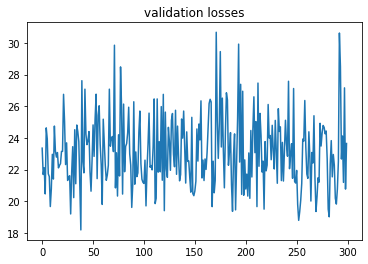

In [155]:
plt.plot([i for i in range(len(train_losses))], [loss.cpu().item() for loss in train_losses])
plt.title('training losses')

plt.plot([i for i in range(len(val_losses))], [loss.cpu().item() for loss in val_losses])
plt.title('validation losses')
plt.show()


In [153]:
from traitlets.traitlets import ClassBasedTraitType
def generate_image_embeddings(image_dataset):
  predictions = []
  for image in image_dataset:
    predictions.append(Clip.vision_ecoder(image))
    
  return torch.stack(predictions)
  

In [154]:
def find_closest_matchs(caption_promt, image_dataset):
  image_embedings = generate_image_embeddings
  text_embeddings = Clip.text_encoder(caption_promt)
  values = torch.matmul(image_embedings,text_embeddings)
  